In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ast
import re
import glob
import os
import json
from tqdm.auto import tqdm
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

try:
    from rapidfuzz import fuzz, process
except ImportError:
    print("Installing rapidfuzz...")
    import sys
    !{sys.executable} -m pip install rapidfuzz -q
    from rapidfuzz import fuzz, process

pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 100)
pd.set_option('display.float_format', '{:.2f}'.format)

sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['font.size'] = 10

In [ ]:
print("Loading Allrecipes data...")
df_recipes = pd.read_csv('Allrecipes_cleaned.csv')

df_recipes['recipe_id'] = df_recipes.index
df_recipes = df_recipes[['recipe_id', 'title', 'total_time', 'ingredients', 'instructions', 'servings', 'nutrients']]

print(f"  Loaded {len(df_recipes):,} recipes")
print(f"  Columns: {list(df_recipes.columns)}")


off_files_gz = glob.glob('OpenFoodFacts/exports/openfoodfacts_complete_*.csv.gz')
off_files_parquet = glob.glob('OpenFoodFacts/exports/openfoodfacts_complete_*.parquet')

latest_off = max(off_files_parquet, key=os.path.getctime)
print(f"Loading from parquet: {os.path.basename(latest_off)}")
df_off = pd.read_parquet(latest_off)

latest_off = max(off_files_gz, key=os.path.getctime)
print(f"Loading from gzip: {os.path.basename(latest_off)}")
df_off = pd.read_csv(latest_off, compression='gzip', low_memory=False)

print(f"Loaded {len(df_off):,} food products")
print(f" Shape: {df_off.shape}")

print("\nLoading NHANES dietary data...")
nhanes_path = 'NHANES/processed/nhanes_dietary_processed.csv'

df_nhanes = pd.read_csv(nhanes_path)
print(f"Loaded {len(df_nhanes):,} dietary records")
print(f"  Unique respondents: {df_nhanes['respondent_id'].nunique():,}")

Loading Allrecipes data...
  Loaded 38,179 recipes
  Columns: ['recipe_id', 'title', 'total_time', 'ingredients', 'instructions', 'servings', 'nutrients']
Loading from parquet: openfoodfacts_complete_20251206_190555.parquet
Loading from gzip: openfoodfacts_complete_20251206_190040.csv.gz
Loaded 4,168,397 food products
 Shape: (4168397, 21)

Loading NHANES dietary data...
Loaded 23,019 dietary records
  Unique respondents: 12,409


In [ ]:
print("Allrecipes Sample:")
print(df_recipes[['recipe_id', 'title', 'ingredients']].head(2))

print("Open Food Facts - Nutrition Columns:")
nutrition_cols = ['product_name', 'energy_100g', 'proteins_100g', 'carbohydrates_100g', 'fat_100g']
available_nutrition_cols = [col for col in nutrition_cols if col in df_off.columns]

for col in available_nutrition_cols:
    pct = (df_off[col].notna().sum() / len(df_off)) * 100
    print(f"  {col}: {pct:.1f}%")

print("NHANES Sample Nutrition Stats:")
nhanes_stats = df_nhanes[['energy_kcal', 'protein_g', 'carbs_g', 'fat_g']].describe()
print(nhanes_stats)

Allrecipes Sample:
   recipe_id                    title  \
0          0  Instant Pistachio Salad   
1          1  Easy Chicken Tetrazzini   

                                                                                           ingredients  
0  ['1 (20 ounce) can crushed pineapple, drained', '1 (3 ounce) package instant pistachio pudding m...  
1  ['1 pound cooked and drained spaghetti', '5 chicken breasts, cooked and cubed', '2 (10.75 ounce)...  
Open Food Facts - Nutrition Columns:
  product_name: 92.2%
  energy_100g: 71.7%
  proteins_100g: 72.2%
  carbohydrates_100g: 72.2%
  fat_100g: 72.1%
NHANES Sample Nutrition Stats:
       energy_kcal  protein_g  carbs_g    fat_g
count     23019.00   23019.00 23019.00 23019.00
mean       1913.87      71.04   228.90    77.58
std         948.79      39.88   119.18    45.92
min           0.00       0.00     0.00     0.00
25%        1266.00      44.35   147.75    45.83
50%        1758.00      63.91   210.41    68.72
75%        2375.50      89

In [ ]:
def parse_ingredient(ingredient_str):
    """
    Enhanced ingredient parser that handles complex formats.
    
    Examples:
        "1 (20 ounce) can crushed pineapple, drained"
        -> quantity=1, unit=can, name=crushed pineapple (with parenthetical_qty=20, parenthetical_unit=oz)
        
        "2 1/2 cups all-purpose flour"
        -> quantity=2.5, unit=cup, name=flour
        
        "1 pound cooked and drained spaghetti"
        -> quantity=1, unit=lb, name=spaghetti
    """
    if not isinstance(ingredient_str, str) or not ingredient_str.strip():
        return {'quantity': None, 'unit': None, 'name': None, 'name_clean': None, 'original': ingredient_str}
    
    original = ingredient_str
    text = ingredient_str.strip()
    

    qty_pattern = r'^(\d+\s+)?\d+/\d+|^\d+\.\d+|^\d+'
    
    quantity = 1.0
    qty_match = re.match(qty_pattern, text)
    
    if qty_match:
        qty_str = qty_match.group(0)
        text = text[len(qty_str):].strip()
        
        try:
            if ' ' in qty_str and '/' in qty_str:  # "2 1/2"
                whole, frac = qty_str.split()
                num, denom = frac.split('/')
                quantity = float(whole) + float(num) / float(denom)
            elif '/' in qty_str:  # "1/2"
                num, denom = qty_str.split('/')
                quantity = float(num) / float(denom)
            else:  # "2" or "2.5"
                quantity = float(qty_str)
        except:
            quantity = 1.0

    paren_pattern = r'\((\d+(?:\.\d+)?)\s+(\w+)\)'
    paren_match = re.search(paren_pattern, text)
    
    parenthetical_qty = None
    parenthetical_unit = None
    
    if paren_match:
        parenthetical_qty = float(paren_match.group(1))
        parenthetical_unit = paren_match.group(2)
        text = re.sub(paren_pattern, '', text).strip()
    
    units_map = {
        # Volume
        'cup': 'cup', 'cups': 'cup', 'c': 'cup',
        'tablespoon': 'tbsp', 'tablespoons': 'tbsp', 'tbsp': 'tbsp', 'tbs': 'tbsp',
        'teaspoon': 'tsp', 'teaspoons': 'tsp', 'tsp': 'tsp',
        'liter': 'l', 'liters': 'l', 'l': 'l',
        'milliliter': 'ml', 'milliliters': 'ml', 'ml': 'ml',
        'fluid': 'fl-oz', 'fl': 'fl-oz',
        # Weight
        'pound': 'lb', 'pounds': 'lb', 'lb': 'lb', 'lbs': 'lb',
        'ounce': 'oz', 'ounces': 'oz', 'oz': 'oz',
        'gram': 'g', 'grams': 'g', 'g': 'g',
        'kilogram': 'kg', 'kilograms': 'kg', 'kg': 'kg',
        # Count/Container
        'pinch': 'pinch', 'dash': 'dash', 'clove': 'clove', 'cloves': 'clove',
        'slice': 'slice', 'slices': 'slice', 
        'can': 'can', 'cans': 'can',
        'package': 'package', 'packages': 'package',
        'container': 'container', 'containers': 'container',
        'cube': 'cube', 'cubes': 'cube',
        'breast': 'breast', 'breasts': 'breast',
    }
    
    unit = None
    words = text.split()
    
    if words:
        potential_unit = words[0].lower().rstrip('s.,()[]')
        if potential_unit in units_map:
            unit = units_map[potential_unit]
            text = ' '.join(words[1:])

    if ',' in text:
        text = text.split(',')[0] 
    
    text = re.sub(r'\([^)]*\)', '', text)
    
    name_clean = text.lower()
    
    modifiers = [
        'fresh', 'frozen', 'dried', 'canned', 
        'chopped', 'diced', 'sliced', 'minced', 'crushed', 
        'ground', 'grated', 'shredded', 
        'cooked', 'raw', 'thawed',
        'large', 'small', 'medium', 
        'whole', 'halved', 'quartered',
        'peeled', 'trimmed', 'boneless', 'skinless',
        'unsalted', 'salted',
        'condensed', 'instant',
        'all-purpose', 'purpose',
        'extra-virgin', 'virgin',
    ]
    
    for modifier in modifiers:
        name_clean = re.sub(r'\b' + modifier + r'\b', '', name_clean, flags=re.IGNORECASE)
    
    name_clean = re.sub(r'[(),]', ' ', name_clean)
    name_clean = re.sub(r'\s+', ' ', name_clean).strip()
    
    name_clean = re.sub(r'^(and|of)\s+', '', name_clean)
    
    return {
        'quantity': quantity,
        'unit': unit,
        'name': text.strip(),  # Original descriptive name
        'name_clean': name_clean if name_clean else text.strip().lower(),  # For matching
        'parenthetical_qty': parenthetical_qty,
        'parenthetical_unit': parenthetical_unit,
        'original': original
    }

In [5]:
test_cases = [
    "2 1/2 cups all-purpose flour",
    "1/2 teaspoon salt",
    "3 large eggs, beaten",
    "1 pound ground beef",
    "2 tablespoons olive oil",
    "pinch of nutmeg"
]

for test in test_cases:
    result = parse_ingredient(test)
    print(f"Input:  '{test}'")
    print(f"Output: qty={result['quantity']}, unit={result['unit']}, name='{result['name_clean']}'")
    print()

Input:  '2 1/2 cups all-purpose flour'
Output: qty=2.5, unit=cup, name='flour'

Input:  '1/2 teaspoon salt'
Output: qty=0.5, unit=tsp, name='salt'

Input:  '3 large eggs, beaten'
Output: qty=3.0, unit=None, name='eggs'

Input:  '1 pound ground beef'
Output: qty=1.0, unit=lb, name='beef'

Input:  '2 tablespoons olive oil'
Output: qty=2.0, unit=tbsp, name='olive oil'

Input:  'pinch of nutmeg'
Output: qty=1.0, unit=pinch, name='nutmeg'



In [ ]:
def safe_parse_list(s):
    """Safely parse string representation of list"""
    if pd.isna(s) or not isinstance(s, str):
        return []
    try:
        return ast.literal_eval(s)
    except:
        return re.findall(r"'(.*?)'", s)

In [7]:
print("Parsing ingredient lists...")
df_recipes['ingredients_list'] = df_recipes['ingredients'].apply(safe_parse_list)

print("Exploding ingredients to individual rows...")
df_ingredients = df_recipes[['recipe_id', 'title', 'ingredients_list']].explode('ingredients_list')
df_ingredients = df_ingredients[df_ingredients['ingredients_list'].notna()].reset_index(drop=True)

print(f"Total ingredient entries: {len(df_ingredients):,}")

Parsing ingredient lists...
Exploding ingredients to individual rows...
Total ingredient entries: 366,949


In [ ]:
print("\nParsing individual ingredients...")
tqdm.pandas(desc="Parsing")
parsed_results = df_ingredients['ingredients_list'].progress_apply(parse_ingredient)

df_parsed = pd.DataFrame(parsed_results.tolist())

df_ingredients_parsed = pd.concat([
    df_ingredients[['recipe_id', 'title']].reset_index(drop=True),
    df_parsed
], axis=1)

print(f"\n Parsed {len(df_ingredients_parsed):,} ingredient entries")
print(f"  Unique ingredients: {df_ingredients_parsed['name_clean'].nunique():,}")
print(f"  Unique recipes: {df_ingredients_parsed['recipe_id'].nunique():,}")


Parsing individual ingredients...


Parsing:   0%|          | 0/366949 [00:00<?, ?it/s]

Parsing: 100%|██████████| 366949/366949 [00:09<00:00, 36979.61it/s]



 Parsed 366,949 ingredient entries
  Unique ingredients: 18,901
  Unique recipes: 38,179


In [9]:
df_ingredients_parsed[['recipe_id', 'quantity', 'unit', 'name', 'name_clean']].head(10)

,recipe_id,quantity,unit,name,name_clean
0,0,1.00,can,crushed pineapple,pineapple
1,0,1.00,package,instant pistachio pudding mix,pistachio pudding mix
2,0,1.00,container,frozen whipped topping,whipped topping
3,0,0.50,package,miniature marshmallows,miniature marshmallows
4,1,1.00,lb,cooked and drained spaghetti,drained spaghetti
5,1,5.00,None,chicken breasts,chicken breasts
6,1,2.00,can,condensed cream of chicken soup,cream of chicken soup
7,1,2.25,cup,water,water
8,1,0.25,cup,butter,butter
9,1,2.00,cube,chicken bouillon,chicken bouillon


In [ ]:
def clean_name(name):
    if not isinstance(name, str):
        return ""
    name = name.lower()
    name = re.sub(r'[(),]', ' ', name)
    name = re.sub(r'\s+', ' ', name).strip()
    return name

df_off['product_name_clean'] = df_off['product_name'].apply(clean_name)

df_off_clean = df_off[
    (df_off['product_name_clean'] != '') & 
    (df_off['product_name_clean'].notna()) & 
    (df_off['product_name_clean'].notnull())].copy()

print(f" Prepared {len(df_off_clean):,} products with nutrition data")

 Prepared 3,841,196 products with nutrition data


In [11]:
unique_ingredients = df_ingredients_parsed['name_clean'].dropna().unique()
print(f"Total unique ingredients to match: {len(unique_ingredients):,}")

Total unique ingredients to match: 18,901


In [ ]:
from collections import defaultdict

off_by_letter = defaultdict(list)
for name in df_off_clean['product_name_clean']:
    if name:
        off_by_letter[name[0]].append(name)

print(f"Created {len(off_by_letter)} letter buckets")

Created 2106 letter buckets


In [ ]:
def fast_fuzzy_match(ingredient_name, min_score=75):
    """
    Optimized fuzzy matching using first-letter filtering
    Lowered to 75% for better coverage
    """
    if not ingredient_name or ingredient_name.strip() == "":
        return None, 0
    
    first_letter = ingredient_name[0]
    candidates = off_by_letter.get(first_letter, [])
    
    if len(candidates) < 50:
        similar_letters = {
            'a': ['e'], 'e': ['a', 'i'], 'i': ['e'],
            'c': ['k', 's'], 'k': ['c'], 's': ['c'],
            'b': ['p'], 'p': ['b']
        }
        for similar in similar_letters.get(first_letter, []):
            candidates.extend(off_by_letter.get(similar, []))
    
    if not candidates:
        return None, 0
    
    result = process.extractOne(
        ingredient_name,
        candidates,
        scorer=fuzz.ratio,
        score_cutoff=min_score
    )
    
    if result:
        matched_name, score, _ = result
        return matched_name, score
    return None, 0


In [ ]:
import time

ingredient_matches = {}
match_scores = {}

batch_size = 100
total_batches = (len(unique_ingredients) + batch_size - 1) // batch_size

start_time = time.time()

for batch_idx in tqdm(range(total_batches), desc="Batches"):
    batch_start = batch_idx * batch_size
    batch_end = min((batch_idx + 1) * batch_size, len(unique_ingredients))
    batch = unique_ingredients[batch_start:batch_end]
    
    for ing in batch:
        matched, score = fast_fuzzy_match(ing)
        if matched:
            ingredient_matches[ing] = matched
            match_scores[ing] = score

elapsed = time.time() - start_time

print(f"\nMatched {len(ingredient_matches)} out of {len(unique_ingredients)} ingredients")
print(f" Coverage: {(len(ingredient_matches)/len(unique_ingredients))*100:.1f}%")
print(f" Average match score: {np.mean(list(match_scores.values())):.1f}%")
print(f" Time taken: {elapsed/60:.1f} minutes")

Batches: 100%|██████████| 190/190 [04:27<00:00,  1.41s/it]


Matched 13779 out of 18901 ingredients
 Coverage: 72.9%
 Average match score: 90.0%
 Time taken: 4.5 minutes


In [15]:
for i, (ing, matched) in enumerate(list(ingredient_matches.items())[:10]):
    score = match_scores[ing]
    print(f"  {ing:<30} -> {matched:<30} ({score:.0f}%)")

  pineapple                      -> pineapple                      (100%)
  pistachio pudding mix          -> pistachio pudding mix          (100%)
  whipped topping                -> whipped topping                (100%)
  miniature marshmallows         -> miniature marshmallows         (100%)
  drained spaghetti              -> dinkel spaghetti               (85%)
  chicken breasts                -> chicken breasts                (100%)
  cream of chicken soup          -> cream of chicken soup          (100%)
  water                          -> water                          (100%)
  butter                         -> butter                         (100%)
  chicken bouillon               -> chicken bouillon               (100%)


In [16]:
matches_df = pd.DataFrame({
    'ingredient': list(ingredient_matches.keys()),
    'matched_to': list(ingredient_matches.values()),
    'score': [match_scores[k] for k in ingredient_matches.keys()]
})
matches_df.to_csv('ingredient_matches.csv', index=False)

In [ ]:
nutrition_lookup = {}

for _, row in df_off.iterrows():
    name = row['product_name_clean']
    nutrition_lookup[name] = {
        'calories': row.get('energy_100g', 0),
        'protein': row.get('proteins_100g', 0),
        'carbs': row.get('carbohydrates_100g', 0),
        'fat': row.get('fat_100g', 0)
    }

print(f" Created nutrition lookup with {len(nutrition_lookup):,} entries")

 Created nutrition lookup with 2,179,248 entries


In [ ]:
UNIT_TO_GRAMS = {
    'cup': 240,
    'tbsp': 15,
    'tsp': 5,
    'oz': 28.35,
    'lb': 453.59,
    'g': 1,
    'kg': 1000,
    'ml': 1,
    'l': 1000,
    'fl-oz': 29.57,
    'pinch': 0.5,
    'dash': 0.6,
    'clove': 3,
    'slice': 30,
    'can': 400, 
    'package': 200, 
    'container': 250,
    'breast': 150, 
    'cube': 10,
    None: 100
}

def calculate_nutrition(row):
    """Calculate nutrition for a single ingredient with parenthetical handling"""
    name_clean = row['name_clean']
    quantity = row['quantity']
    unit = row['unit']
    
    if pd.notna(row.get('parenthetical_qty')):
        quantity = row['parenthetical_qty']
        paren_unit = row.get('parenthetical_unit', '').lower()
        if 'ounce' in paren_unit or paren_unit == 'oz':
            unit = 'oz'
        elif 'pound' in paren_unit or paren_unit == 'lb':
            unit = 'lb'
        elif 'gram' in paren_unit or paren_unit == 'g':
            unit = 'g'
    
    if name_clean not in ingredient_matches:
        return None
    
    matched_name = ingredient_matches[name_clean]
    
    if matched_name not in nutrition_lookup:
        return None
    
    nutr = nutrition_lookup[matched_name]
    
    grams = quantity * UNIT_TO_GRAMS.get(unit, 100)
    
    factor = grams / 100.0
    
    return {
        'calories': nutr['calories'] * factor,
        'protein': nutr['protein'] * factor,
        'carbs': nutr['carbs'] * factor,
        'fat': nutr['fat'] * factor,
        'matched_to': matched_name,
        'grams_used': grams
    }


print("Calculating nutrition for each ingredient...")
tqdm.pandas(desc="Calculating")
nutrition_results = df_ingredients_parsed.progress_apply(calculate_nutrition, axis=1)

nutrition_clean = [
    x if isinstance(x, dict) else {} 
    for x in nutrition_results
]

nutrition_df = pd.DataFrame(nutrition_clean)
df_ingredients_parsed = pd.concat([df_ingredients_parsed, nutrition_df], axis=1)

coverage = df_ingredients_parsed['matched_to'].notna().sum()
print(f"\n Calculated nutrition for {coverage:,} ingredient entries")
print(f" Coverage: {(coverage/len(df_ingredients_parsed))*100:.1f}%")

Calculating nutrition for each ingredient...


Calculating: 100%|██████████| 366949/366949 [00:04<00:00, 86032.34it/s] 



 Calculated nutrition for 352,084 ingredient entries
 Coverage: 95.9%


In [ ]:
print("\nSample nutrition calculations:")
sample = df_ingredients_parsed[[
    'recipe_id', 'original', 'quantity', 'unit', 
    'calories', 'protein', 'carbs', 'fat', 'matched_to'
]].dropna().head(5)
sample


Sample nutrition calculations:


,recipe_id,original,quantity,unit,calories,protein,carbs,fat,matched_to
1,0,1 (3 ounce) package instant pistachio pudding mix,1.00,package,306.18,0.68,78.25,1.70,pistachio pudding mix
2,0,"1 (8 ounce) container frozen whipped topping, thawed",1.00,container,567.00,0.00,68.04,34.02,whipped topping
4,1,1 pound cooked and drained spaghetti,1.00,lb,1632.92,49.89,335.66,6.80,dinkel spaghetti
8,1,0.25 cup butter,0.25,cup,448.20,0.36,0.48,49.38,butter
9,1,2 cubes chicken bouillon,2.00,cube,1.60,0.08,0.17,0.06,chicken bouillon


In [ ]:
recipe_nutrition = df_ingredients_parsed.groupby('recipe_id').agg({
    'calories': lambda x: x.dropna().sum() if x.notna().any() else np.nan,
    'protein': lambda x: x.dropna().sum() if x.notna().any() else np.nan,
    'carbs': lambda x: x.dropna().sum() if x.notna().any() else np.nan,
    'fat': lambda x: x.dropna().sum() if x.notna().any() else np.nan
}).reset_index()

recipe_nutrition.columns = ['recipe_id', 'calc_calories', 'calc_protein', 'calc_carbs', 'calc_fat']

print(f" Calculated nutrition for {len(recipe_nutrition):,} recipes")

df_recipes_final = df_recipes.merge(recipe_nutrition, on='recipe_id', how='left')

print(f"  Recipes with calculated nutrition: {df_recipes_final['calc_calories'].notna().sum():,}")

df_recipes_final['servings'] = pd.to_numeric(df_recipes_final['servings'], errors='coerce').fillna(4)

df_recipes_final['calc_calories_per_serving'] = df_recipes_final['calc_calories'] / df_recipes_final['servings']
df_recipes_final['calc_protein_per_serving'] = df_recipes_final['calc_protein'] / df_recipes_final['servings']
df_recipes_final['calc_carbs_per_serving'] = df_recipes_final['calc_carbs'] / df_recipes_final['servings']
df_recipes_final['calc_fat_per_serving'] = df_recipes_final['calc_fat'] / df_recipes_final['servings']

print(f"  Average servings per recipe: {df_recipes_final['servings'].mean():.1f}")

def parse_nutrients(nutr_str):
    try:
        if pd.isna(nutr_str):
            return {}
        return ast.literal_eval(nutr_str)
    except:
        return {}

df_recipes_final['nutrients_dict'] = df_recipes_final['nutrients'].apply(parse_nutrients)

def extract_nutrient(nutr_dict, key, aliases=[]):
    """Extract nutrient with multiple possible key names"""
    if not nutr_dict:
        return np.nan
    
    for k in [key] + aliases:
        if k in nutr_dict:
            val = nutr_dict[k]
            if isinstance(val, str):
                val = re.sub(r'[a-zA-Z\s]', '', val).strip()
                try:
                    return float(val)
                except:
                    continue
            try:
                return float(val)
            except:
                continue
    return np.nan

df_recipes_final['orig_calories'] = df_recipes_final['nutrients_dict'].apply(
    lambda x: extract_nutrient(x, 'calories', ['Calories', 'calories per serving', 'energy'])
)
df_recipes_final['orig_protein'] = df_recipes_final['nutrients_dict'].apply(
    lambda x: extract_nutrient(x, 'protein', ['Protein', 'protein g'])
)
df_recipes_final['orig_carbs'] = df_recipes_final['nutrients_dict'].apply(
    lambda x: extract_nutrient(x, 'carbohydrates', ['Carbohydrates', 'carbs', 'total carbs'])
)
df_recipes_final['orig_fat'] = df_recipes_final['nutrients_dict'].apply(
    lambda x: extract_nutrient(x, 'fat', ['Fat', 'total fat', 'fat g'])
)

def is_realistic(row):
    """Check if nutrition values are realistic"""
    cal = row['calc_calories_per_serving']
    if pd.isna(cal):
        return False
    if cal < 50 or cal > 2000:
        return False
    protein = row['calc_protein_per_serving']
    if pd.notna(protein) and (protein < 0 or protein > 100):
        return False
    return True

df_recipes_final['nutrition_realistic'] = df_recipes_final.apply(is_realistic, axis=1)

print(f"  Recipes with realistic nutrition: {df_recipes_final['nutrition_realistic'].sum():,}")

print("\nComparison (Calculated vs Original - Per Serving):")
comparison = df_recipes_final[[
    'recipe_id', 'title', 'servings',
    'calc_calories_per_serving', 'orig_calories', 
    'calc_protein_per_serving', 'orig_protein',
    'calc_carbs_per_serving', 'orig_carbs',
    'calc_fat_per_serving', 'orig_fat'
]].dropna(subset=['calc_calories_per_serving', 'orig_calories'])

corr = comparison['calc_calories_per_serving'].corr(comparison['orig_calories'])
print(f"  Calorie correlation: {corr:.3f}")

 Calculated nutrition for 38,179 recipes
  Recipes with calculated nutrition: 37,907
  Average servings per recipe: 4.0
  Recipes with realistic nutrition: 33,823

Comparison (Calculated vs Original - Per Serving):
  Calorie correlation: 0.092


In [21]:
comparison.head(10)

,recipe_id,title,servings,calc_calories_per_serving,orig_calories,calc_protein_per_serving,orig_protein,calc_carbs_per_serving,orig_carbs,calc_fat_per_serving,orig_fat
0,0,Instant Pistachio Salad,4.00,218.30,159.00,0.17,NaN,36.57,NaN,8.93,NaN
1,1,Easy Chicken Tetrazzini,4.00,520.68,473.00,12.58,NaN,84.08,NaN,14.06,NaN
2,2,Green Pea Salad With Cheddar Cheese,4.00,735.91,386.00,22.87,NaN,32.67,NaN,54.93,NaN
3,3,Chilled Strawberry Soup,4.00,697.20,252.00,7.92,NaN,116.35,NaN,27.27,NaN
4,4,Fried Mac and Cheese Balls,4.00,3658.74,543.00,54.03,NaN,170.59,NaN,306.92,NaN
5,5,Napa Cabbage Salad,4.00,733.79,632.00,2.68,NaN,45.69,NaN,61.83,NaN
6,6,Red Cabbage Salad,4.00,279.79,225.00,0.24,NaN,4.63,NaN,30.06,NaN
7,7,Cinnamon Ice Cream,4.00,912.30,279.00,5.85,NaN,94.33,NaN,55.75,NaN
8,8,Homemade Blueberry Pie,4.00,245.47,366.00,0.02,NaN,54.53,NaN,3.09,NaN
9,9,Thanksgiving Sweet Potatoes,4.00,233.81,428.00,1.76,NaN,58.82,NaN,0.00,NaN


In [22]:
print(f"Total recipes: {len(df_recipes_final):,}")
print(f"With calculated nutrition: {df_recipes_final['calc_calories'].notna().sum():,}")
print(f"With realistic nutrition: {df_recipes_final['nutrition_realistic'].sum():,}")
print(f"Coverage: {(df_recipes_final['nutrition_realistic'].sum()/len(df_recipes_final))*100:.1f}%")

Total recipes: 38,179
With calculated nutrition: 37,907
With realistic nutrition: 33,823
Coverage: 88.6%


In [23]:
print("Calories per serving distribution:")
print(df_recipes_final['calc_calories_per_serving'].describe())

Calories per serving distribution:
count   37907.00
mean      804.62
std      1782.57
min         0.00
25%       275.66
50%       558.50
75%       993.21
max     74707.49
Name: calc_calories_per_serving, dtype: float64


In [24]:
nhanes_stats = {
    'energy_kcal': df_nhanes['energy_kcal'].describe(),
    'protein_g': df_nhanes['protein_g'].describe(),
    'carbs_g': df_nhanes['carbs_g'].describe(),
    'fat_g': df_nhanes['fat_g'].describe()
}

print("NHANES Daily Intake (Full Day)")
print(f"  Calories: {nhanes_stats['energy_kcal']['mean']:.0f} ± {nhanes_stats['energy_kcal']['std']:.0f} kcal")
print(f"  Protein:  {nhanes_stats['protein_g']['mean']:.1f} ± {nhanes_stats['protein_g']['std']:.1f} g")
print(f"  Carbs:    {nhanes_stats['carbs_g']['mean']:.1f} ± {nhanes_stats['carbs_g']['std']:.1f} g")
print(f"  Fat:      {nhanes_stats['fat_g']['mean']:.1f} ± {nhanes_stats['fat_g']['std']:.1f} g")


NHANES Daily Intake (Full Day)
  Calories: 1914 ± 949 kcal
  Protein:  71.0 ± 39.9 g
  Carbs:    228.9 ± 119.2 g
  Fat:      77.6 ± 45.9 g


In [ ]:

df_realistic = df_recipes_final[df_recipes_final['nutrition_realistic'] == True]

recipe_stats = df_realistic[[
    'calc_calories_per_serving', 
    'calc_protein_per_serving', 
    'calc_carbs_per_serving', 
    'calc_fat_per_serving'
]].describe()

print("Recipe Per-serving (Single Meal)")
print(f"  Calories: {recipe_stats.loc['mean', 'calc_calories_per_serving']:.0f} ± {recipe_stats.loc['std', 'calc_calories_per_serving']:.0f} kcal")
print(f"  Protein:  {recipe_stats.loc['mean', 'calc_protein_per_serving']:.1f} ± {recipe_stats.loc['std', 'calc_protein_per_serving']:.1f} g")
print(f"  Carbs:    {recipe_stats.loc['mean', 'calc_carbs_per_serving']:.1f} ± {recipe_stats.loc['std', 'calc_carbs_per_serving']:.1f} g")
print(f"  Fat:      {recipe_stats.loc['mean', 'calc_fat_per_serving']:.1f} ± {recipe_stats.loc['std', 'calc_fat_per_serving']:.1f} g")

Recipe Per-serving (Single Meal)
  Calories: 645 ± 449 kcal
  Protein:  18.6 ± 18.8 g
  Carbs:    69.2 ± 67.1 g
  Fat:      33.4 ± 29.2 g


### Assume 3 meals per day, compare recipe to 1/3 of daily intake

In [26]:
nhanes_per_meal = {
    'calories': nhanes_stats['energy_kcal']['mean'] / 3,
    'protein': nhanes_stats['protein_g']['mean'] / 3,
    'carbs': nhanes_stats['carbs_g']['mean'] / 3,
    'fat': nhanes_stats['fat_g']['mean'] / 3
}

recipe_per_meal = {
    'calories': recipe_stats.loc['mean', 'calc_calories_per_serving'],
    'protein': recipe_stats.loc['mean', 'calc_protein_per_serving'],
    'carbs': recipe_stats.loc['mean', 'calc_carbs_per_serving'],
    'fat': recipe_stats.loc['mean', 'calc_fat_per_serving']
}

print("Benchmark: Recipe vs NHANES (Per Meal)")

print(f"{'Nutrient':<12} {'NHANES/3':<12} {'Recipe':<12} {'Difference':<12}")

for nutrient in ['calories', 'protein', 'carbs', 'fat']:
    nhanes_val = nhanes_per_meal[nutrient]
    recipe_val = recipe_per_meal[nutrient]
    diff_pct = ((recipe_val - nhanes_val) / nhanes_val) * 100
    
    print(f"{nutrient.capitalize():<12} {nhanes_val:>10.1f}  {recipe_val:>10.1f}  {diff_pct:>+9.1f}%")

Benchmark: Recipe vs NHANES (Per Meal)
Nutrient     NHANES/3     Recipe       Difference  
Calories          638.0       645.4       +1.2%
Protein            23.7        18.6      -21.3%
Carbs              76.3        69.2       -9.3%
Fat                25.9        33.4      +29.3%


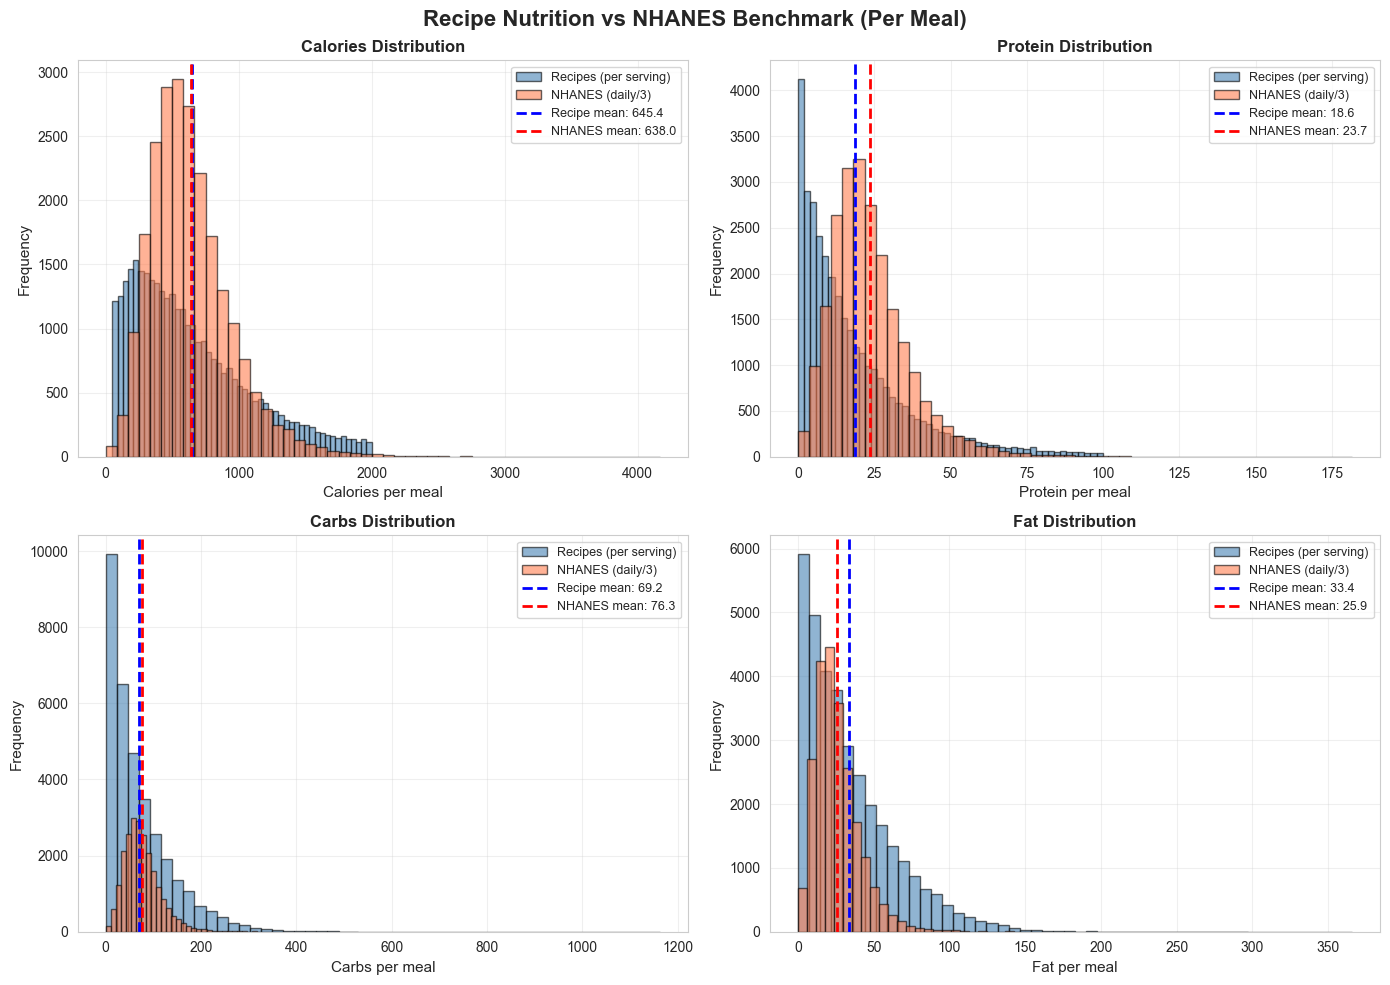

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Recipe Nutrition vs NHANES Benchmark (Per Meal)', fontsize=16, fontweight='bold')

nutrients = ['calories', 'protein', 'carbs', 'fat']
recipe_cols = ['calc_calories_per_serving', 'calc_protein_per_serving', 
               'calc_carbs_per_serving', 'calc_fat_per_serving']
nhanes_cols = ['energy_kcal', 'protein_g', 'carbs_g', 'fat_g']

for idx, (nutrient, recipe_col, nhanes_col) in enumerate(zip(nutrients, recipe_cols, nhanes_cols)):
    ax = axes[idx // 2, idx % 2]
    
    # Recipe distribution (per serving)
    recipe_data = df_realistic[recipe_col].dropna()
    ax.hist(recipe_data, bins=50, alpha=0.6, label='Recipes (per serving)', 
            color='steelblue', edgecolor='black')
    
    # NHANES distribution (divided by 3 for per-meal)
    nhanes_data = df_nhanes[nhanes_col].dropna() / 3
    ax.hist(nhanes_data, bins=50, alpha=0.6, label='NHANES (daily/3)', 
            color='coral', edgecolor='black')
    
    ax.axvline(recipe_data.mean(), color='blue', linestyle='--', linewidth=2, 
               label=f'Recipe mean: {recipe_data.mean():.1f}')
    ax.axvline(nhanes_data.mean(), color='red', linestyle='--', linewidth=2,
               label=f'NHANES mean: {nhanes_data.mean():.1f}')
    
    ax.set_xlabel(f'{nutrient.capitalize()} per meal', fontsize=11)
    ax.set_ylabel('Frequency', fontsize=11)
    ax.set_title(f'{nutrient.capitalize()} Distribution', fontsize=12, fontweight='bold')
    ax.legend(fontsize=9)
    ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()


In [ ]:
print("Missing Nutrition Data:")
print(f"  Zero calories: {(df_realistic['calc_calories_per_serving'] == 0).sum():,} recipes")
print(f"  Zero protein: {(df_realistic['calc_protein_per_serving'] == 0).sum():,} recipes")
print(f"  Zero carbs: {(df_realistic['calc_carbs_per_serving'] == 0).sum():,} recipes")
print(f"  Zero fat: {(df_realistic['calc_fat_per_serving'] == 0).sum():,} recipes")

ingredient_coverage = df_ingredients_parsed.groupby('recipe_id').agg({
    'matched_to': lambda x: (x.notna().sum() / len(x)) * 100
}).reset_index()
ingredient_coverage.columns = ['recipe_id', 'match_coverage_pct']

df_recipes_final = df_recipes_final.merge(ingredient_coverage, on='recipe_id', how='left')

print(f"\nIngredient Matching Coverage:")
print(f"  Mean coverage per recipe: {ingredient_coverage['match_coverage_pct'].mean():.1f}%")
print(f"  Recipes with >80% match: {(ingredient_coverage['match_coverage_pct'] > 80).sum():,}")
print(f"  Recipes with <50% match: {(ingredient_coverage['match_coverage_pct'] < 50).sum():,}")

zero_carb_recipes = df_realistic[df_realistic['calc_carbs_per_serving'] == 0][
    ['recipe_id', 'title', 'calc_calories_per_serving', 'calc_protein_per_serving', 
     'calc_carbs_per_serving', 'calc_fat_per_serving']
].head(10)

Missing Nutrition Data:
  Zero calories: 0 recipes
  Zero protein: 722 recipes
  Zero carbs: 187 recipes
  Zero fat: 923 recipes

Ingredient Matching Coverage:
  Mean coverage per recipe: 95.5%
  Recipes with >80% match: 35,684
  Recipes with <50% match: 109


722 recipes missing protein, 923 missing fat

In [ ]:
valid_nutrition_mask = (
    (df_realistic['calc_calories_per_serving'] > 0) &
    (df_realistic['calc_protein_per_serving'] > 0) &
    (df_realistic['calc_carbs_per_serving'] > 0) &
    (df_realistic['calc_fat_per_serving'] > 0)
)

df_clean = df_realistic[valid_nutrition_mask].copy()

print(f"Original recipe count: {len(df_realistic):,}")
print(f"Recipes removed (zero nutrition): {len(df_realistic) - len(df_clean):,}")
print(f"Cleaned recipe count: {len(df_clean):,}")

print("\nVerifying Zeros in Cleaned Data:")
print(f"  Zero protein: {(df_clean['calc_protein_per_serving'] == 0).sum()}")
print(f"  Zero fat:     {(df_clean['calc_fat_per_serving'] == 0).sum()}")
print(f"  Zero carbs:   {(df_clean['calc_carbs_per_serving'] == 0).sum()}")

Original recipe count: 33,823
Recipes removed (zero nutrition): 1,355
Cleaned recipe count: 32,468

Verifying Zeros in Cleaned Data:
  Zero protein: 0
  Zero fat:     0
  Zero carbs:   0


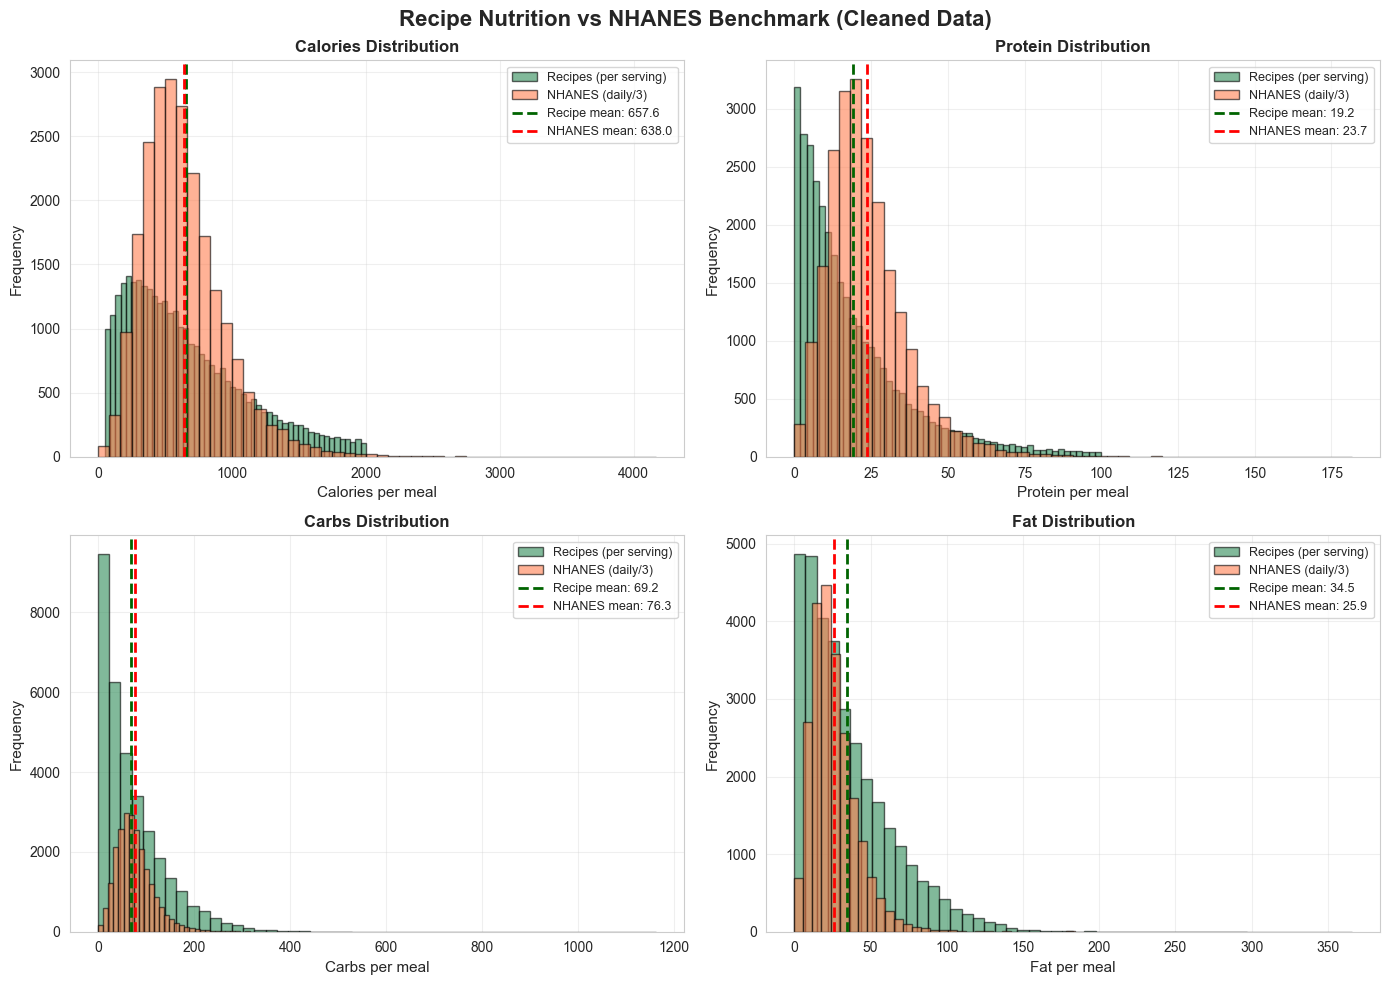

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Recipe Nutrition vs NHANES Benchmark (Cleaned Data)', fontsize=16, fontweight='bold')

nutrients = ['calories', 'protein', 'carbs', 'fat']
recipe_cols = ['calc_calories_per_serving', 'calc_protein_per_serving', 
               'calc_carbs_per_serving', 'calc_fat_per_serving']
nhanes_cols = ['energy_kcal', 'protein_g', 'carbs_g', 'fat_g']

for idx, (nutrient, recipe_col, nhanes_col) in enumerate(zip(nutrients, recipe_cols, nhanes_cols)):
    ax = axes[idx // 2, idx % 2]
    
    recipe_data = df_clean[recipe_col].dropna()
    ax.hist(recipe_data, bins=50, alpha=0.6, label='Recipes (per serving)', 
            color='seagreen', edgecolor='black')
    
    nhanes_data = df_nhanes[nhanes_col].dropna() / 3
    ax.hist(nhanes_data, bins=50, alpha=0.6, label='NHANES (daily/3)', 
            color='coral', edgecolor='black')
    
    ax.axvline(recipe_data.mean(), color='darkgreen', linestyle='--', linewidth=2, 
               label=f'Recipe mean: {recipe_data.mean():.1f}')
    ax.axvline(nhanes_data.mean(), color='red', linestyle='--', linewidth=2,
               label=f'NHANES mean: {nhanes_data.mean():.1f}')
    
    ax.set_xlabel(f'{nutrient.capitalize()} per meal', fontsize=11)
    ax.set_ylabel('Frequency', fontsize=11)
    ax.set_title(f'{nutrient.capitalize()} Distribution', fontsize=12, fontweight='bold')
    ax.legend(fontsize=9)
    ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

In [ ]:
ingredient_coverage = df_ingredients_parsed.groupby('recipe_id').agg({
    'matched_to': lambda x: (x.notna().sum() / len(x)) * 100 if len(x) > 0 else 0
}).reset_index()
ingredient_coverage.columns = ['recipe_id', 'match_coverage_pct']

df_recipes_final = df_recipes_final.merge(ingredient_coverage, on='recipe_id', how='left')

df_recipes_final['match_coverage_pct'] = df_recipes_final['match_coverage_pct'].fillna(0)

print(f" Added match coverage to {len(df_recipes_final):,} recipes")
print(f"  Mean coverage: {df_recipes_final['match_coverage_pct'].mean():.1f}%")
print(f"  Recipes >80% coverage: {(df_recipes_final['match_coverage_pct'] > 80).sum():,}")
print(f"  Recipes <50% coverage: {(df_recipes_final['match_coverage_pct'] < 50).sum():,}")

 Added match coverage to 38,179 recipes
  Mean coverage: 95.5%
  Recipes >80% coverage: 35,684
  Recipes <50% coverage: 109


In [32]:
df_model_ready = df_recipes_final[
    (df_recipes_final['nutrition_realistic'] == True) &
    (df_recipes_final['calc_calories_per_serving'].notna()) &
    (df_recipes_final['match_coverage_pct'] > 70) &
    (df_recipes_final['instructions'].notna()) &
    (df_recipes_final['instructions'].str.len() > 50)
].copy()

print(f" Filtered to {len(df_model_ready):,} high-quality recipes")
print(f"  Original: {len(df_recipes_final):,} recipes")
print(f"  Removed: {len(df_recipes_final) - len(df_model_ready):,} low-quality recipes")

 Filtered to 33,303 high-quality recipes
  Original: 38,179 recipes
  Removed: 4,876 low-quality recipes


In [ ]:
recipe_export = df_model_ready[[
    'recipe_id', 
    'title', 
    'total_time', 
    'servings',
    'calc_calories_per_serving',
    'calc_protein_per_serving',
    'calc_carbs_per_serving',
    'calc_fat_per_serving',
    'match_coverage_pct',
    'ingredients'
]].copy()

recipe_export.rename(columns={
    'calc_calories_per_serving': 'calories',
    'calc_protein_per_serving': 'protein',
    'calc_carbs_per_serving': 'carbs',
    'calc_fat_per_serving': 'fat'
}, inplace=True)

recipe_export.to_csv('nutrigen_recipes_final.csv', index=False)
print(f" Saved {len(recipe_export):,} recipes to: nutrigen_recipes_final.csv")
print(f"  Columns: {list(recipe_export.columns)}")

 Saved 33,303 recipes to: nutrigen_recipes_final.csv
  Columns: ['recipe_id', 'title', 'total_time', 'servings', 'calories', 'protein', 'carbs', 'fat', 'match_coverage_pct', 'ingredients']


In [42]:
print(" Nutrition Summary (per serving):")
print(f"    Calories: {recipe_export['calories'].mean():.0f} ± {recipe_export['calories'].std():.0f} kcal")
print(f"    Protein:  {recipe_export['protein'].mean():.1f} ± {recipe_export['protein'].std():.1f} g")
print(f"    Carbs:    {recipe_export['carbs'].mean():.1f} ± {recipe_export['carbs'].std():.1f} g")
print(f"    Fat:      {recipe_export['fat'].mean():.1f} ± {recipe_export['fat'].std():.1f} g")

 Nutrition Summary (per serving):
    Calories: 649 ± 449 kcal
    Protein:  18.8 ± 18.8 g
    Carbs:    69.5 ± 67.1 g
    Fat:      33.7 ± 29.3 g


In [ ]:
instruction_export = df_model_ready[[
    'recipe_id', 
    'title', 
    'ingredients', 
    'instructions',
    'servings',
    'calc_calories_per_serving',
    'calc_protein_per_serving',
    'calc_carbs_per_serving',
    'calc_fat_per_serving'
]].copy()

instruction_export.rename(columns={
    'calc_calories_per_serving': 'calories',
    'calc_protein_per_serving': 'protein',
    'calc_carbs_per_serving': 'carbs',
    'calc_fat_per_serving': 'fat'
}, inplace=True)

def clean_instructions(text):
    """Clean instruction text for model training"""
    if pd.isna(text):
        return ""
    text = str(text)
    text = re.sub(r'\s+', ' ', text)
    text = re.sub(r'[^\w\s.,;:!?()\-\'\"°]', '', text)
    return text.strip()

instruction_export['instructions'] = instruction_export['instructions'].apply(clean_instructions)

instruction_export = instruction_export[instruction_export['instructions'].str.len() > 100]

instruction_export.to_csv('nutrigen_instructions.csv', index=False)
print(f" Saved {len(instruction_export):,} recipes to: nutrigen_instructions.csv")
print(f"  Columns: {list(instruction_export.columns)}")

 Saved 33,151 recipes to: nutrigen_instructions.csv
  Columns: ['recipe_id', 'title', 'ingredients', 'instructions', 'servings', 'calories', 'protein', 'carbs', 'fat']


In [ ]:
from sklearn.model_selection import train_test_split

train_ids, test_ids = train_test_split(
    recipe_export['recipe_id'], 
    test_size=0.2, 
    random_state=42
)

recipe_train = recipe_export[recipe_export['recipe_id'].isin(train_ids)]
recipe_test = recipe_export[recipe_export['recipe_id'].isin(test_ids)]

recipe_train.to_csv('nutrigen_recipes_train.csv', index=False)
recipe_test.to_csv('nutrigen_recipes_test.csv', index=False)

inst_train = instruction_export[instruction_export['recipe_id'].isin(train_ids)]
inst_test = instruction_export[instruction_export['recipe_id'].isin(test_ids)]

inst_train.to_csv('nutrigen_instructions_train.csv', index=False)
inst_test.to_csv('nutrigen_instructions_test.csv', index=False)

print(f" Train set: {len(recipe_train):,} recipes")
print(f" Test set:  {len(recipe_test):,} recipes")

 Train set: 26,642 recipes
 Test set:  6,661 recipes
